In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from PIL import Image
from matplotlib.path import Path
from scipy.spatial import Delaunay

# Used later for boundary checks
eps = 0.5

### Import image and save dimensions

In [ ]:
image = Image.open("dog.png")
image_data = np.array(image.convert("L"))

height, width = image_data.shape

print(f"Height: {height}")
print(f"Width: {width}")

Height: 469
Width: 600


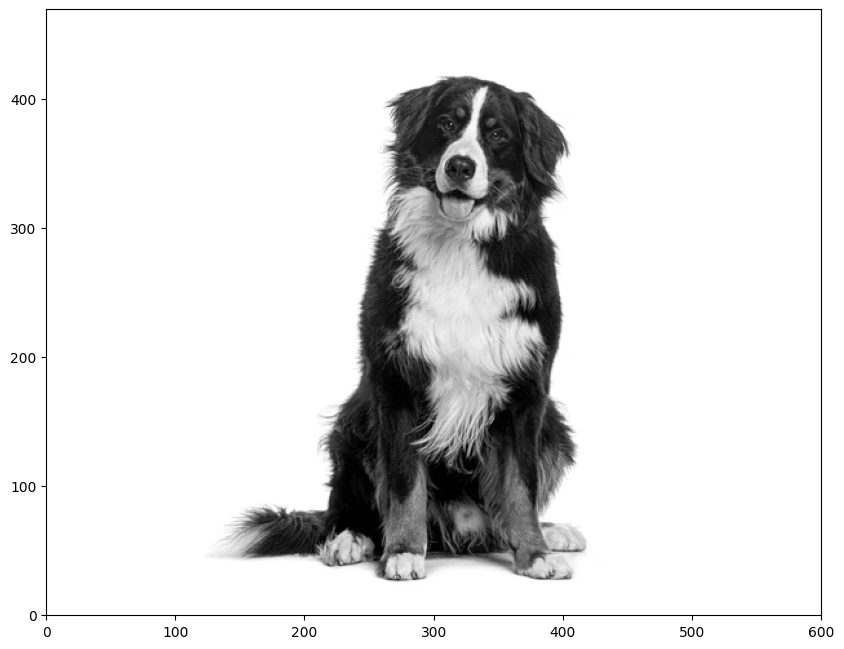

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap="gray", extent=[0, width, 0, height])

### Initial Plot of a Voronoi Diagram (Not Bounded)

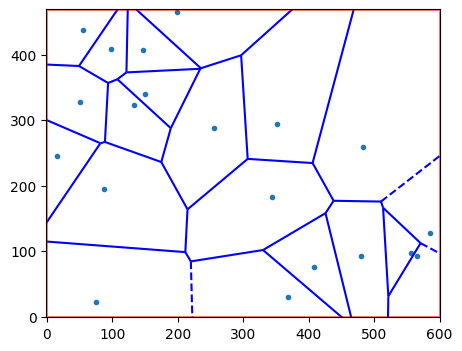

In [ ]:
num_sites = 20

test_sites = np.column_stack((
    np.random.uniform(0, width, num_sites),
    np.random.uniform(0, height, num_sites)
))

fig, ax = plt.subplots(figsize=(8, 4))

vor = Voronoi(test_sites)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1.5)

region = np.array([[0, 0], [width, 0], [width, height], [0, height]])
region_closed = np.vstack([region, region[0]])
ax.plot(region_closed[:, 0], region_closed[:, 1], 'r-', alpha=0.5)

ax.set_aspect('equal')
ax.set_xlim(-1, width + 0.5)
ax.set_ylim(-1, height + 0.5)

plt.show()

In [ ]:
def relax_voronoi_weighted(bounded_vor, bounds, image, num_iter):
    start_vor = bounded_vor

    for i in range(num_iter):
        new_centroids = calculate_all_centroids_weighted(start_vor, image)
        new_vor = bounded_voronoi(new_centroids, bounds)
        start_vor = new_vor

    return start_vor

### Bounded Voronoi Functions

In [ ]:
def in_bounding_box(sites, bounds):
    x_min, x_max, y_min, y_max = bounds
    return (sites[:, 0] >= x_min) & (sites[:, 0] <= x_max) & (sites[:, 1] >= y_min) & (sites[:, 1] <= y_max)

In [ ]:
def bounded_voronoi(sites, bounds):
    x_min, x_max, y_min, y_max = bounds
    inside_indices = in_bounding_box(sites, bounds)

    points_center = sites[inside_indices]

    points_left = np.copy(points_center)
    points_left[:, 0] = x_min - (points_left[:, 0] - x_min)

    points_right = np.copy(points_center)
    points_right[:, 0] = x_max + (x_max - points_right[:, 0])

    points_down = np.copy(points_center)
    points_down[:, 1] = y_min - (points_down[:, 1] - y_min)

    points_up = np.copy(points_center)
    points_up[:, 1] = y_max + (y_max - points_up[:, 1])

    all_points = np.vstack([points_center, points_left, points_right, points_down, points_up])

    vor = Voronoi(all_points)

    regions = []
    for _, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        valid_region = True
        for index in region:
            if index == -1:
                valid_region = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(bounds[0] - eps <= x and x <= bounds[1] + eps and
                       bounds[2] - eps <= y and y <= bounds[3] + eps):
                    valid_region = False
                    break
        if region != [] and valid_region:
            regions.append(region)

    vor.filtered_points = points_center
    vor.filtered_regions = regions
    return vor

In [ ]:
def calculate_centroid(vertices):
    A = 0
    Cx = 0
    Cy = 0

    for i in range(0, len(vertices) - 1):
        s = (vertices[i, 0] * vertices[i + 1, 1] - vertices[i + 1, 0] * vertices[i, 1])
        A += s
        Cx += (vertices[i, 0] + vertices[i + 1, 0]) * s
        Cy += (vertices[i, 1] + vertices[i + 1, 1]) * s

    A *= 0.5
    Cx *= (1 / (6 * A))
    Cy *= (1 / (6 * A))

    return np.array([float(Cx), float(Cy)])

In [ ]:
def calculate_all_centroids_unweighted(vor):

    centroids = []
    for region in vor.filtered_regions:
        vertices = vor.vertices[region, :]
        vertices = np.vstack([vertices, vor.vertices[region[0], :]])
        centroid = calculate_centroid(vertices)
        centroids.append(centroid)

    return np.array(centroids)

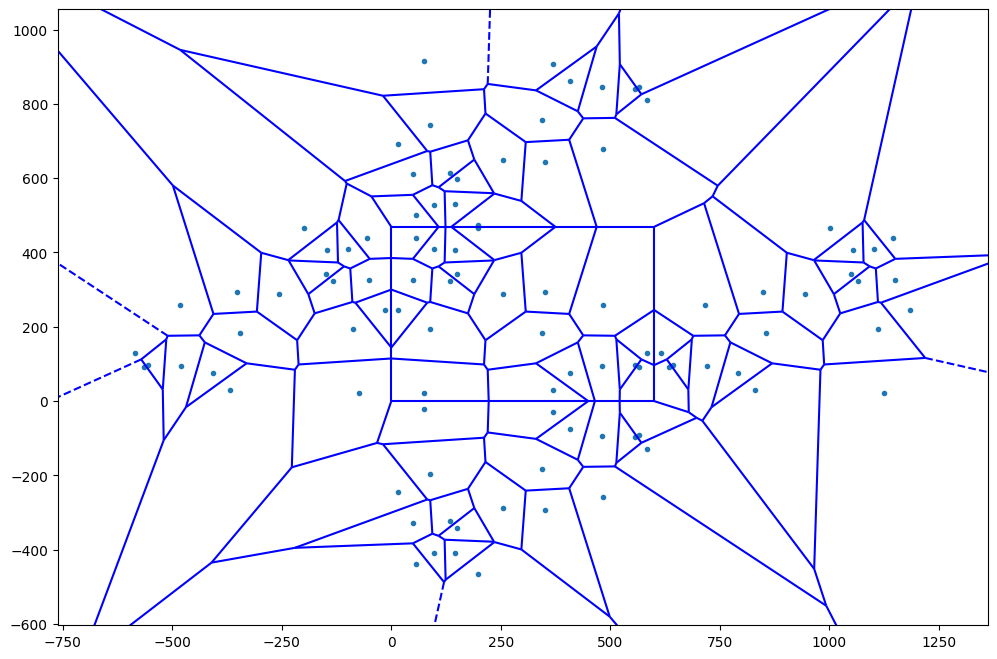

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

test_bounded_vor = bounded_voronoi(test_sites, np.array([0, width, 0, height]))
voronoi_plot_2d(test_bounded_vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1.5)
plt.show()

### Print a Voronoi Diagram that is Bounded (already run through function)

In [ ]:
def print_bounded_voronoi(vor, show_regions=True, show_vertices=False, show_sites=False, show_centroids=False):

    if show_sites:
        ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], 'b.')

    if show_centroids:
        vor_centroids = calculate_all_centroids_unweighted(vor)
        ax.plot(vor_centroids[:, 0], vor_centroids[:, 1], 'r.')

    if show_regions:
        for region in vor.filtered_regions:
            vertices = vor.vertices[region, :]

            if show_vertices:
                ax.plot(vertices[:, 0], vertices[:, 1], 'g.')

            vertices = np.vstack([vertices, vor.vertices[region[0], :]])
            ax.plot(vertices[:, 0], vertices[:, 1], 'k-')


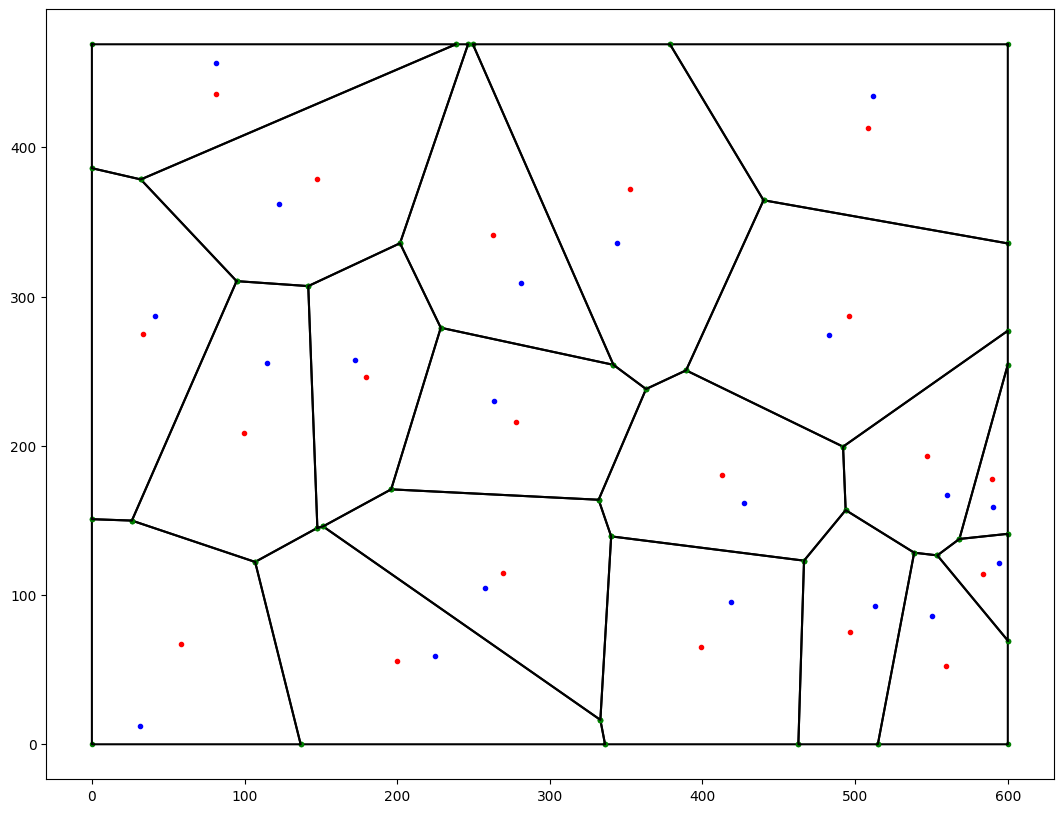

In [ ]:
bounding_box = np.array([0., width, 0., height]) # [x_min, x_max, y_min, y_max]

bounded_points = bounded_voronoi(test_sites, bounding_box)

fig, ax = plt.subplots(figsize=(13, 10))
print_bounded_voronoi(bounded_points, show_sites=True, show_centroids=True, show_vertices=True)
plt.show()

### Perform the Voronoi Relaxation Algorithm (Lloyd's Algorithm)

In [ ]:
def relax_voronoi(bounded_vor, bounds, num_iter):
    start_vor = bounded_vor

    for i in range(num_iter):
        new_centroids = calculate_all_centroids_unweighted(start_vor)
        new_vor = bounded_voronoi(new_centroids, bounds)
        start_vor = new_vor

    return start_vor

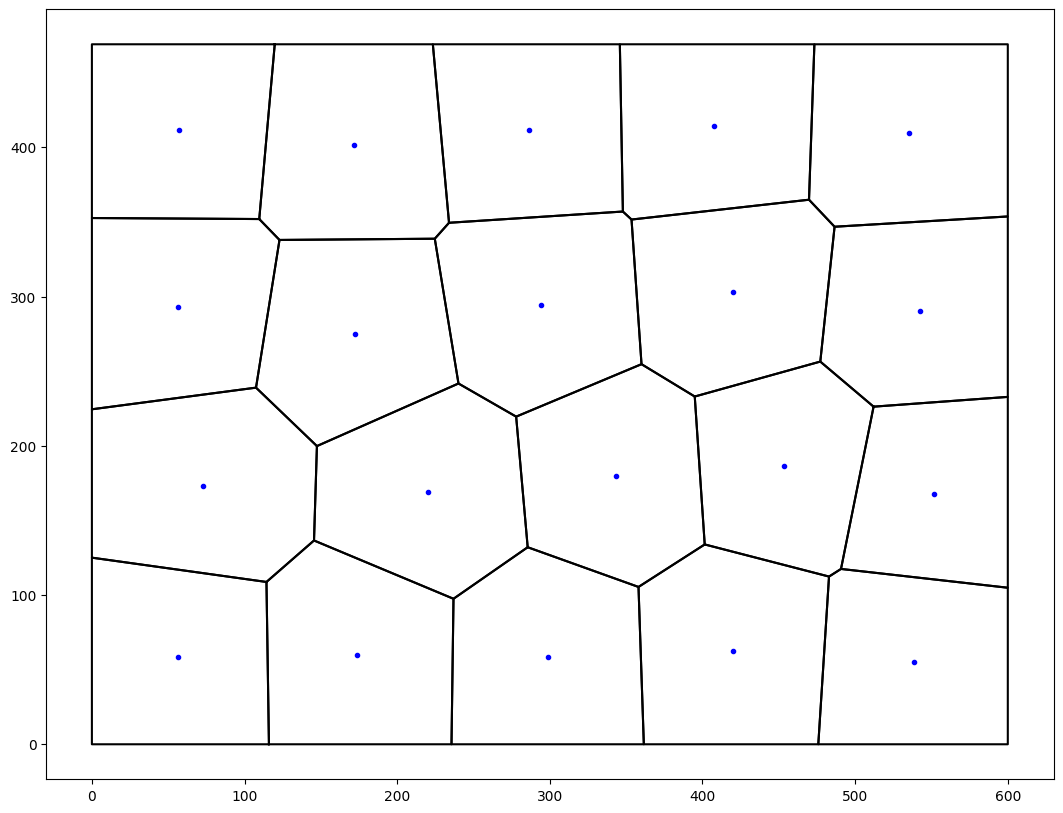

In [ ]:
relaxed_vor = relax_voronoi(bounded_points, bounding_box, 30)

fig, ax = plt.subplots(figsize=(13, 10))
print_bounded_voronoi(relaxed_vor, show_sites=True)
plt.show()

### Generate Points for Weighted Voronoi Stipple

Randomly generated points (even if probability weighted by brightness) are not ideal because they result in jagged and non-uniform groupings of points

However, I will use these randomly generated points to make the algorithm converge quicker.

In [ ]:
def generate_base_points(image, n_points, max_brightness = 100):

    # Initial points provided a general estimate of where the image lies,
    # if it's too light then ignore and place the point somewhere else

    height, width = image.shape

    points = []

    while len(points) < n_points:
        x_float = np.random.rand() * width
        y_float = np.random.rand() * height
        x = np.floor(x_float).astype(int)
        y = np.floor(y_float).astype(int)

        if image[y, x] <= max_brightness:
            y_inverted = height - y_float
            points.append((x_float, y_inverted))

    # Convert the list of points to a NumPy array and return it
    return np.array(points)

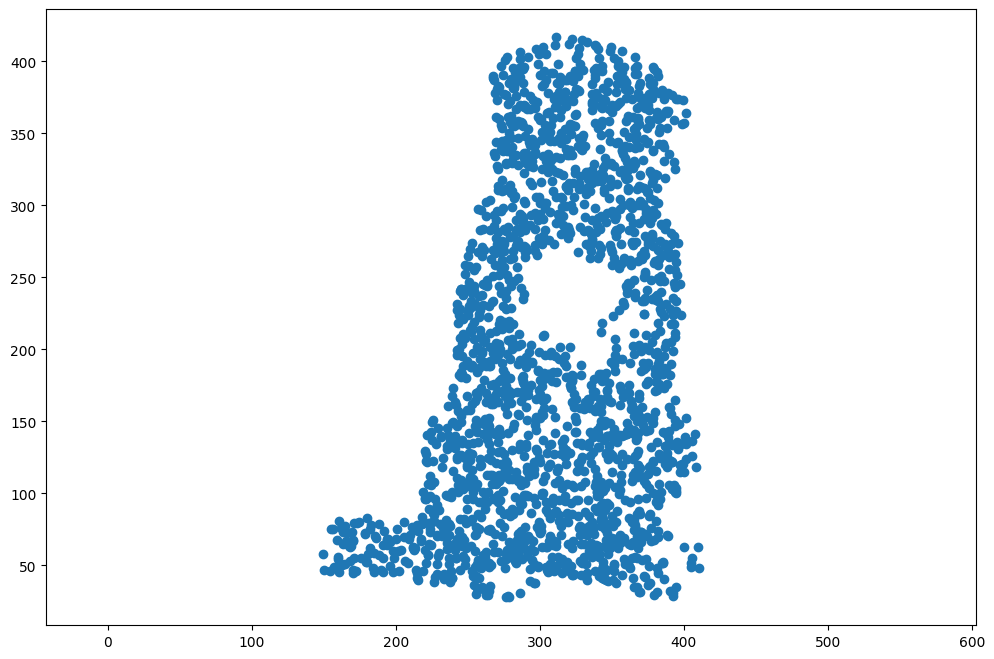

In [ ]:
num_points = 2000

test_points = generate_base_points(image_data, num_points, max_brightness=200)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(test_points[:, 0], test_points[:, 1])
ax.axis('equal')
plt.show()

### Why we can't just use regular Voronoi Relaxation

Blurred image is not really what we're looking for, although it does make the image smoother which is cool

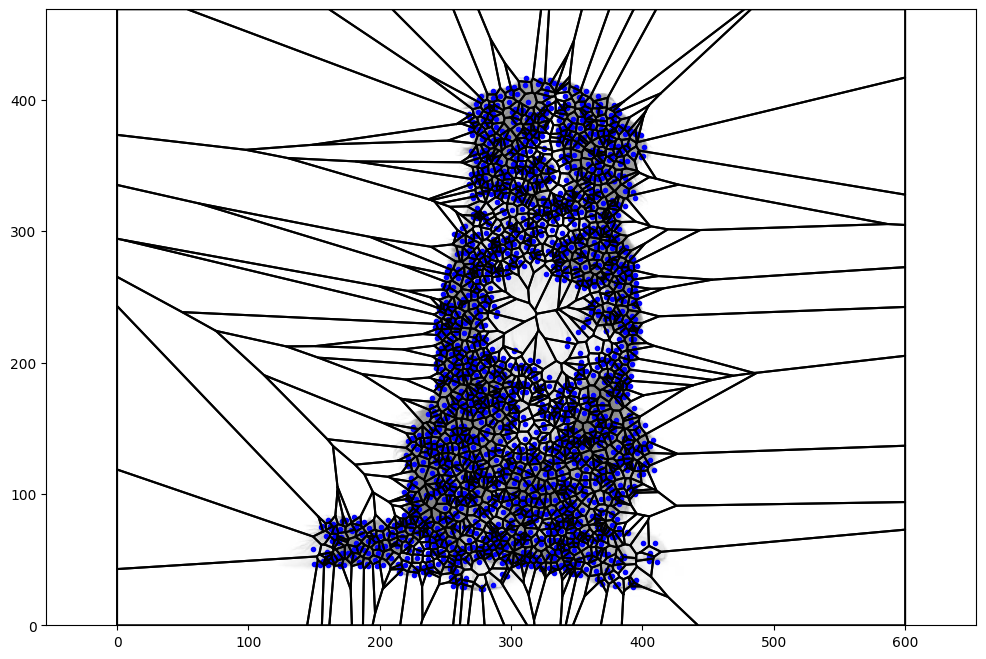

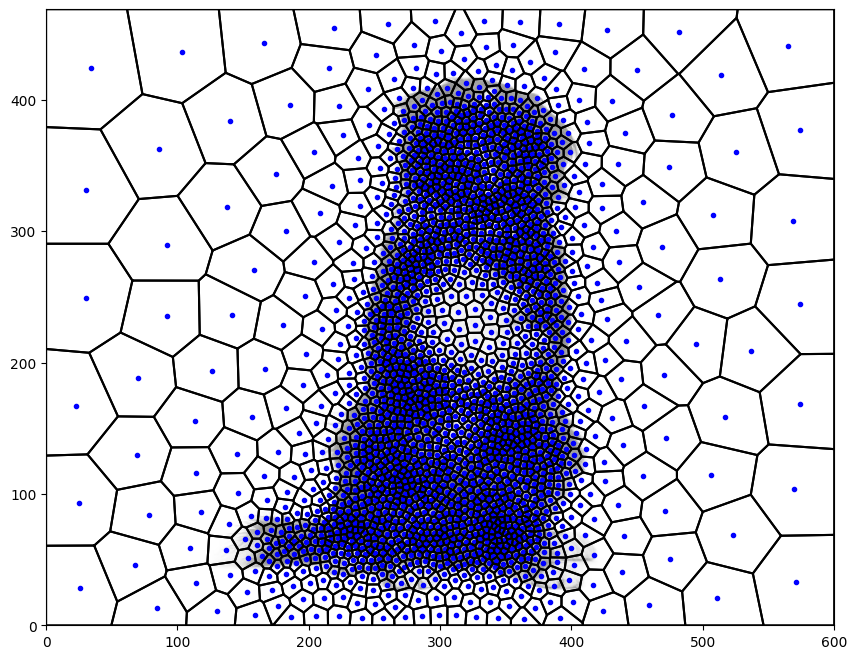

In [ ]:
dog_vor = bounded_voronoi(test_points, bounding_box)

fig, ax = plt.subplots(figsize=(12, 8))
plt.axis('equal')
print_bounded_voronoi(dog_vor, show_sites=True, show_regions=True)
ax.imshow(image_data, cmap="gray", extent=[0, width, 0, height], alpha=0.5)
plt.show()

dog_vor_relaxed = relax_voronoi(dog_vor, bounding_box, 10)
fig, ax = plt.subplots(figsize=(12, 8))
print_bounded_voronoi(dog_vor_relaxed, show_sites=True, show_regions=True)
ax.imshow(image_data, cmap="gray", extent=[0, width, 0, height], alpha=0.5)
plt.show()

### Calculating Weighted Centroids

In [ ]:
def calculate_all_centroids_weighted(vor, image):
    centroids = []

    height, width = image.shape

    for region in vor.filtered_regions:

        region_vertices = vor.vertices[region]
        min_x, min_y = np.min(region_vertices, axis=0)
        max_x, max_y = np.max(region_vertices, axis=0)

        min_x = max(int(min_x), 0)
        min_y = max(int(min_y), 0)
        max_x = min(int(max_x), width - 1)
        max_y = min(int(max_y), height - 1)

        weighted_sum_x = 0.0
        weighted_sum_y = 0.0
        total_weight = 0.0

        for x in range(int(min_x), int(max_x) + 1):
            for y in range(int(min_y), int(max_y) + 1):
                if point_in_polygon((x, y), region, vor):
                    adjusted_y = height - 1 - y

                    weight = 255.0 - float(image[adjusted_y, x])

                    weighted_sum_x += x * weight
                    weighted_sum_y += y * weight
                    total_weight += weight

        if total_weight > 0:
            centroid_x = weighted_sum_x / total_weight
            centroid_y = weighted_sum_y / total_weight
            centroids.append([centroid_x, centroid_y])

    return np.array(centroids)

# Check if pixel is inside of the polygon
def point_in_polygon(point, region, vor):
    polygon = Path(vor.vertices[region])
    return polygon.contains_point(point)

### Plotting the Unweighted Centroids (red) vs the Weighted Centroids (magenta)

It's easier to see them towards the outer edges of the region with the dog in it

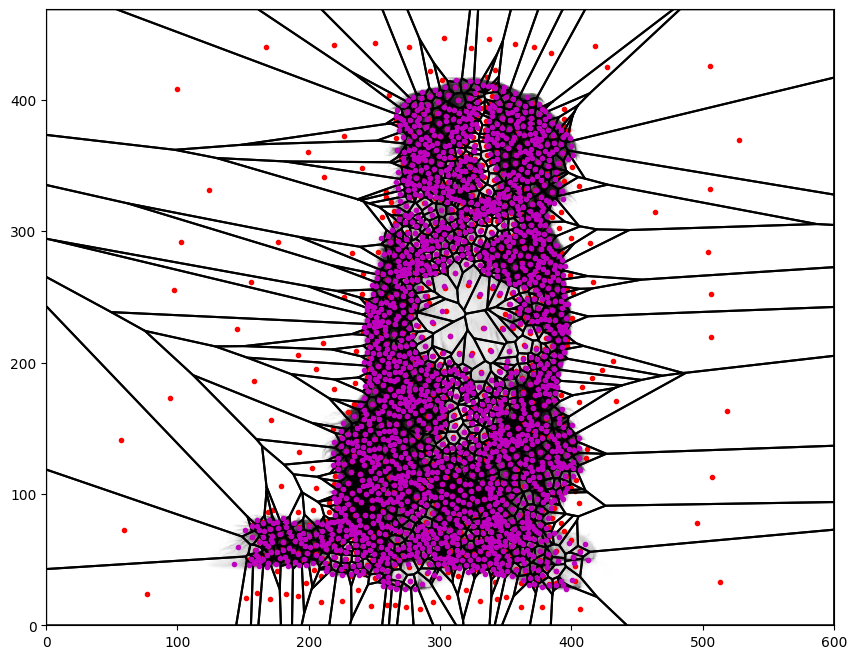

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(image_data, cmap="gray", extent=[0, width, 0, height])

bounded_test_points = bounded_voronoi(test_points, bounding_box)
weighted_centroids = calculate_all_centroids_weighted(bounded_test_points, image_data)
print_bounded_voronoi(bounded_test_points, show_centroids=True)

ax.plot(weighted_centroids[:, 0], weighted_centroids[:, 1], 'm.')

### Weighted Voronoi Relaxation (aka Weighted Voronoi Stippling)

In [ ]:
def relax_voronoi_weighted(bounded_vor, bounds, image, num_iter):
    start_vor = bounded_vor

    for i in range(num_iter):
        new_centroids = calculate_all_centroids_weighted(start_vor, image)
        new_vor = bounded_voronoi(new_centroids, bounds)
        start_vor = new_vor

    return start_vor

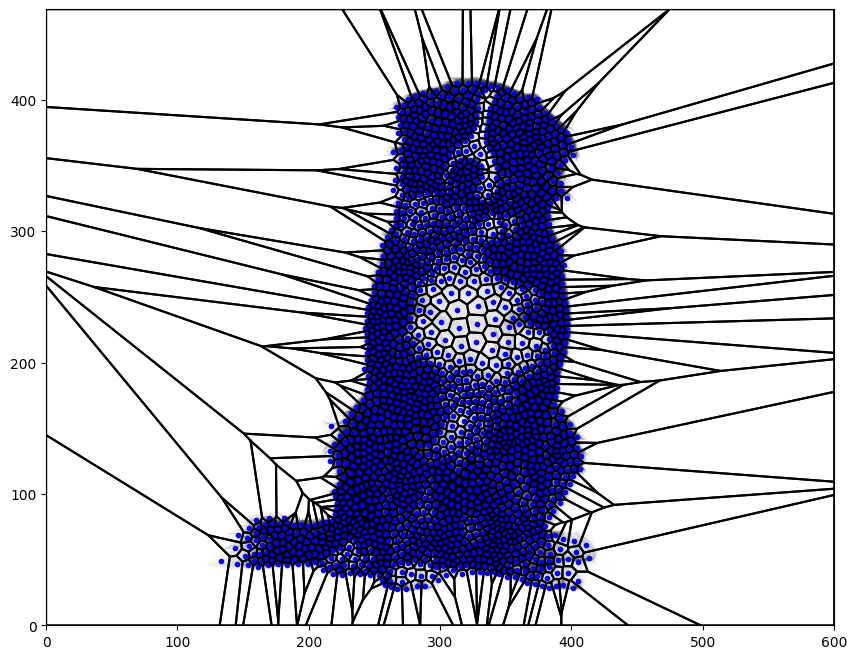

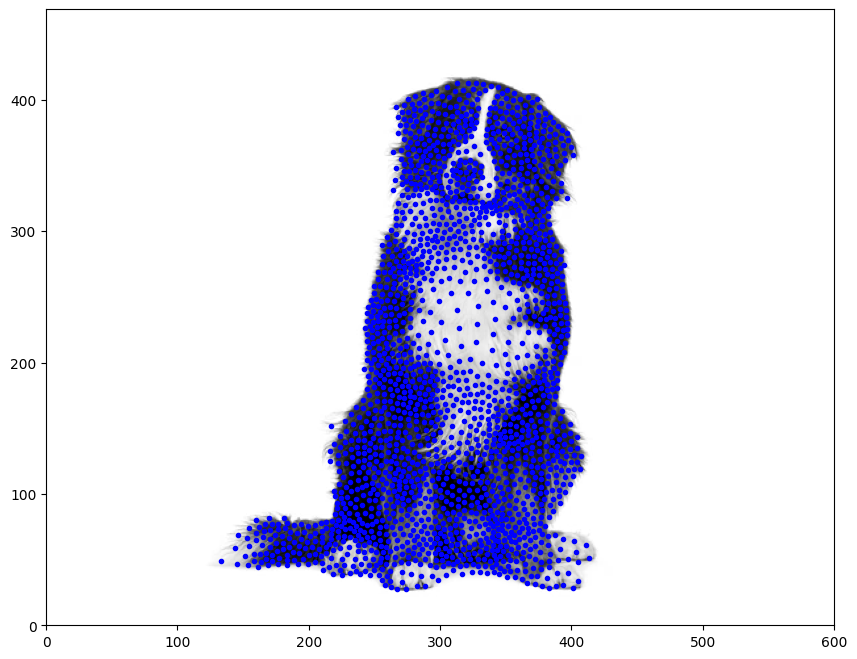

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(image_data, cmap="gray", extent=[0, width, 0, height])

weighted_relaxed_dog = relax_voronoi_weighted(bounded_test_points, bounding_box, image_data, 10)

print_bounded_voronoi(weighted_relaxed_dog, show_sites=True)

plt.show()



fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(image_data, cmap="gray", extent=[0, width, 0, height])

print_bounded_voronoi(weighted_relaxed_dog, show_sites=True, show_regions=False)

plt.show()

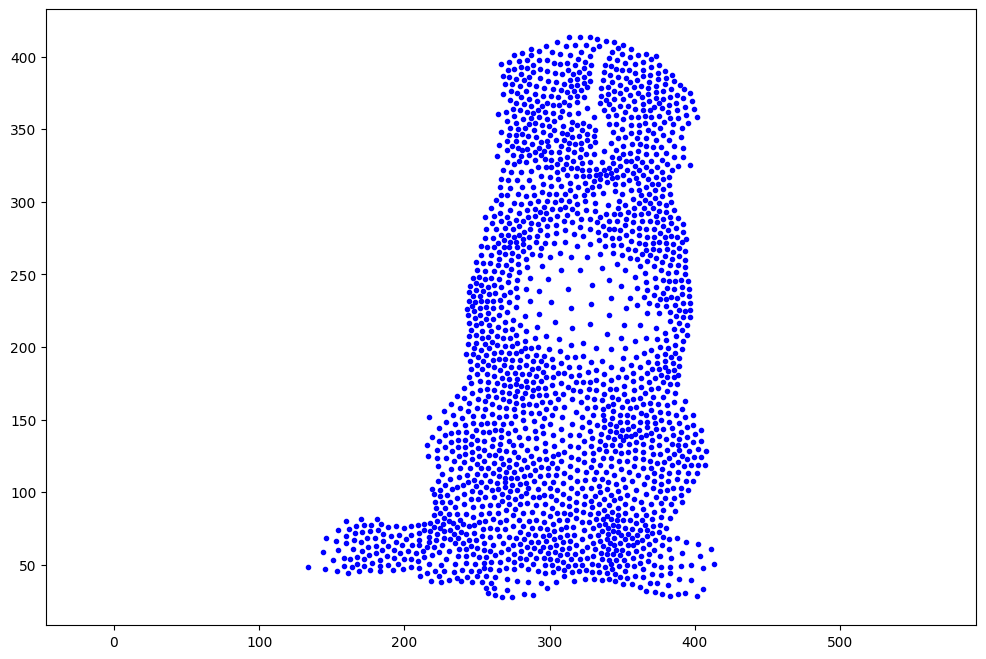

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.axis('equal')
print_bounded_voronoi(weighted_relaxed_dog, show_sites=True, show_regions=False)

plt.show()

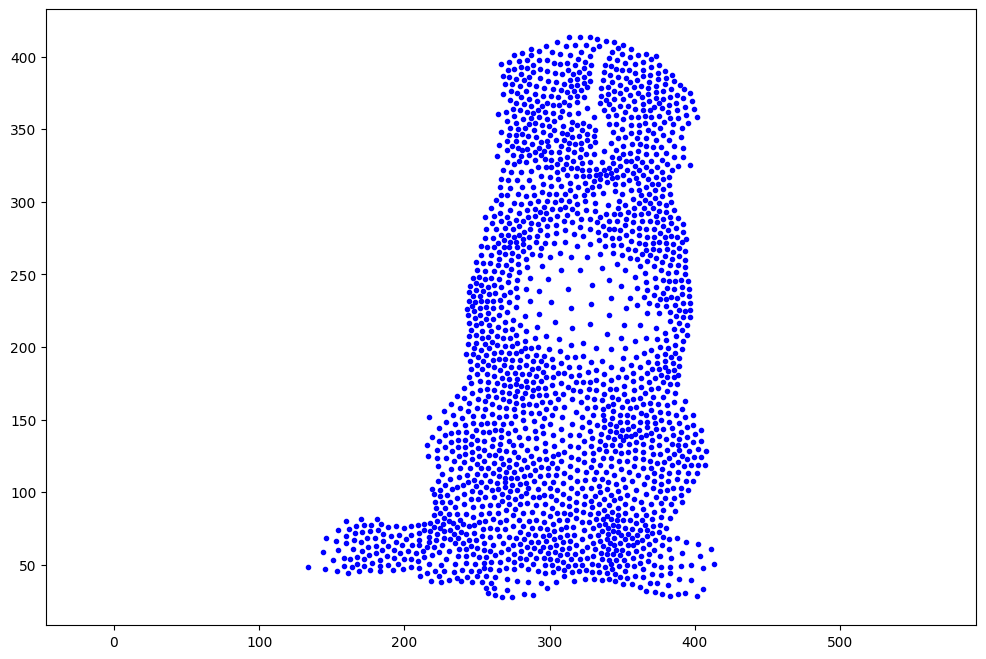

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.axis('equal')
print_bounded_voronoi(weighted_relaxed_dog, show_sites=True, show_regions=False)

plt.show()

### Delaunay Triangulation of Weighted Voronoi Stipple

Sadly doesn't look too good :(

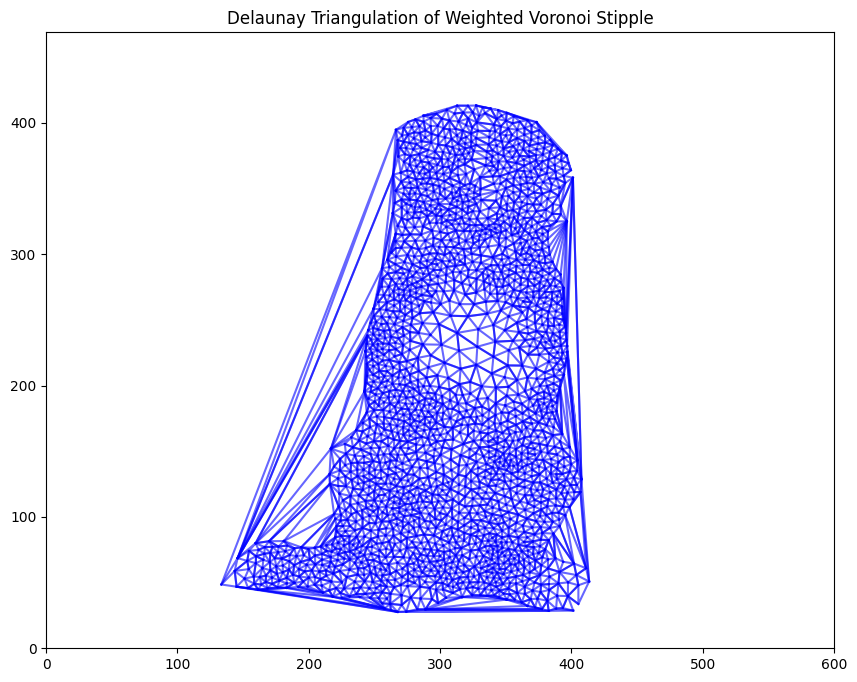

In [ ]:
stipple_points = weighted_relaxed_dog.filtered_points

tri = Delaunay(stipple_points)

fig, ax = plt.subplots(figsize=(12, 8))

for simplex in tri.simplices:
    simplex_points = stipple_points[simplex]
    ax.plot(simplex_points[:, 0], simplex_points[:, 1], "b-", alpha=0.6)

ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.set_aspect("equal")
ax.set_title('Delaunay Triangulation of Weighted Voronoi Stipple')
plt.show()